In [1]:
import tqdm
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm import tqdm
import scipy.integrate as integrate
import scipy.optimize as spo
from random import sample
from numpy import pi
from scipy.optimize import fsolve
from math import sqrt, exp, tanh
import math
import matplotlib.colors as mcolors
from matplotlib import cm
from mpmath import mp 

mp.dps = 10 # desired decimal digits when calling from the mpmath library
IB = 30 # upper integration bound for all integrals

# The activation function

We are interested in the positive activation function

$$ \phi^{\text{pos}}(x;g,\theta) = \frac{1}{2} \left[ \tanh(g(x-\theta))+1\right]
$$ 

but we define it with an argument that can choose between this and a plain tanh 

$$ \phi^{\text{odd}}(x;g,\theta) =  \tanh(g(x-\theta))$$ 



In [2]:
def phi(x,g=1,th=0,f ="pos"):
    if f == "pos":
        return((math.tanh(g*(x-th))+1)/2)
    if f == "tanh":
        return(math.tanh(g*(x-th)))
    
def d_phi(x,g=1,th=0,f ="pos"): #first derivative of the activation function
    if f == "pos":
        return((g/2)*((mp.sech(g*(x-th)))**2))
    if f == "tanh":
        return(g*(mp.sech(g*(x-th))**2))
    
def dd_phi(x,g=1,th=0,d=1,f ="pos"):
    if f == "pos":
        return(-g*g*tanh(g*(x-th))*((mp.sech(g*(x-th)))**2))
    if f == "tanh":
        return(-g*g*tanh(g*(x-th))*((mp.sech(g*(x-th)))**2)/2)    

# The self-consistency equations

The parameters M and C are to be found by solving the set of equations 

$$ \tilde{M}  (M,C; g,\theta,J_0,\sigma) \equiv J_0 
\int \frac{d x}{\sqrt{2 \pi}} e^{-x^2/2}
\phi\left( \sqrt{C} x + M ; g, \theta  \right)   = M
$$

$$ \tilde{C}  (M,C; g,\theta,J_0,\sigma) \equiv \sigma^2 + \int \frac{d x}{\sqrt{2 \pi}}  e^{-x^2/2} \int \phi\left( \sqrt{C} x 
 + M ; g, \theta  \right)^2  = C
$$ 



In [3]:
# We define some preliminary functions needed to solve the self-consistency equations 

def Nor(x):
    return(exp(-x**2 / 2) / (sqrt(2*pi)))

def F0(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:phi(sqrt(C) * x + M,g=g,th=th,f =f)*Nor(x), -IB,IB,epsabs = tol)[0])

def F00(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:(phi(sqrt(C) * x + M,g=g,th=th,f =f)**2)*Nor(x), -IB,IB,epsabs = tol)[0])


In [4]:
# The formulas for M and C

def M_impl(M,C,g=1,th=0,J0=0,sig=0,f="pos"): #implicit expression for LLE in terms of M and C 
    return(J0*F0(M,C,g=g,th=th,f=f))

def C_impl(M,C,g=1,th=0,J0=0,sig=0,f="pos"): #implicit expression for LLE in terms of M and C 
     return(sig**2+ F00(M,C,g=g,th=th,f=f))


# The rootfinder 

Now we neeed to build a solver that can find multiple roots. First let's define all the integrals

In [5]:
def F1(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:d_phi(sqrt(C) * x + M,g=g,th=th,f =f)*Nor(x), -IB,IB,epsabs = tol)[0])

def F11(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:(d_phi(sqrt(C) * x + M,g=g,th=th,f =f)**2)*Nor(x), -IB,IB,epsabs = tol)[0])


In [6]:
def F2(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:dd_phi(sqrt(C) * x + M,g=g,th=th,f =f)*Nor(x), -IB,IB,epsabs = tol)[0])

def F22(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:(dd_phi(sqrt(C) * x + M,g=g,th=th,f =f)**2)*Nor(x), -IB,IB,epsabs =tol)[0])


In [7]:
def F10(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:d_phi(sqrt(C) * x + M,g=g,th=th,f =f)*phi(sqrt(C) * x + M,g=g,th=th,f =f)*Nor(x), -IB,IB,epsabs = tol)[0])

def F20(M,C,g=1,th=0,f="pos",tol= 1e-12): 
    return(integrate.quad(lambda x:dd_phi(sqrt(C) * x + M,g=g,th=th,f =f)*phi(sqrt(C) * x + M,g=g,th=th,f =f)*Nor(x), -IB,IB,epsabs = tol)[0])

In [8]:
def root_finder(M=-10,C=10,eps=1,g=1,th=0,J0=0,sig=0,f="pos",tol= 1e-12): 

    while eps > 1e-10:
        C = sig**2+F00(M,C,g=g,th=th,f=f,tol=tol)
        M = J0 * F0(M,C,g=g,th=th,f=f,tol=tol)
        eps = np.abs(C-sig**2-F00(M,C,g=g,th=th,f=f,tol=tol))+np.abs(M-J0*F0(M,C,g=g,th=th,f=f,tol=tol)) #absolute error

    return(M,C)

Sanity check : let's see if in the classic case (for J0=sig=th=M=0 and f="tanh"), which is monostable, the nonzero fixed point appears at g=1 as it should

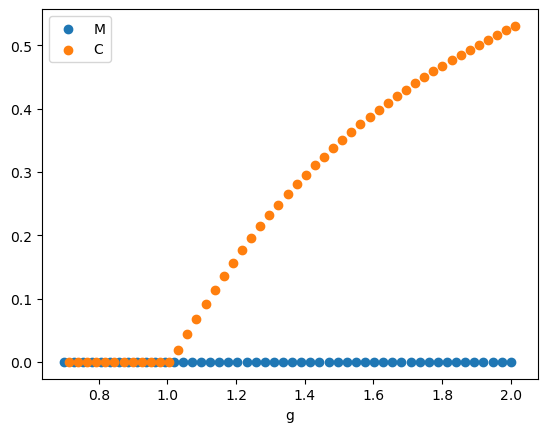

In [9]:
gs=np.linspace(.7,2)
Cs=[]
Ms=[]

for g in gs: 
    M,C=root_finder(g=g,th=0,J0=0,sig=0,f="tanh")
    Cs.append(C)
    Ms.append(M)

plt.scatter(gs, Ms,label="M")
plt.scatter(gs+np.mean(np.diff(gs))/2, Cs,label="C")
plt.xlabel("g")
plt.legend()

# The Lyapunov Exponent

We are interested in the Lyapunov Exponent $\lambda(g,\theta,J_0,\sigma)$ defined as 

$$\lambda  (g,\theta,J_0,\sigma) = \frac{1}{2} \int \frac{d x}{\sqrt{2 \pi}} e^{-x^2/2} \phi'\left(\sqrt{C} x + M ; g, \theta \right)^2 
 $$ 


In [10]:
log2 = lambda x: math.log(x,2)

def LLE_func(M,C,g=1,th=0,J0=0,sig=0,f="pos",tol=1e-12):
    return(0.5*log2(F11(M,C,g=g,th=th,f=f,tol=tol)))
    
def LLE(g=1,th=0,J0=0,sig=0,f="pos",tol=1e-12):
    M,C = root_finder(g=g,th=th,J0=J0,sig=sig,f=f,tol=tol)
    return(LLE_func(M,C,g=g,th=th,J0=J0,sig=sig,f=f,tol=tol))



In [11]:
# let us also quantify the local single-replica stability

def loc_func(M,C,g=1,th=0,J0=0,sig=0,f="pos",tol=1e-12): 
    loc=(J0*F1(M,C,g=g,th=th,f=f,tol=tol)-1)*(F20(M,C,g=g,th=th,f=f,tol=tol)+F11(M,C,g=g,th=th,f=f,tol=tol)-1)\
                -J0*F10(M,C,g=g,th=th,f=f,tol=tol)*F2(M,C,g=g,th=th,f=f,tol=tol) 
    return(loc)

def loc(g=1,th=0,J0=0,sig=0,f="pos",tol=1e-12):
    M,C = root_finder(g=g,th=th,J0=J0,sig=sig,f=f,tol=tol)
    return(loc_func(M,C,g=g,th=th,J0=J0,sig=sig,f=f,tol=tol))
   

*Sanity check:* If I set the parameters (theta,J0,sigma) all four to zero, and choose the tanh activation function, I should be able to recover that the LLE changes sign at g=1

Text(0, 0.5, 'LLE')

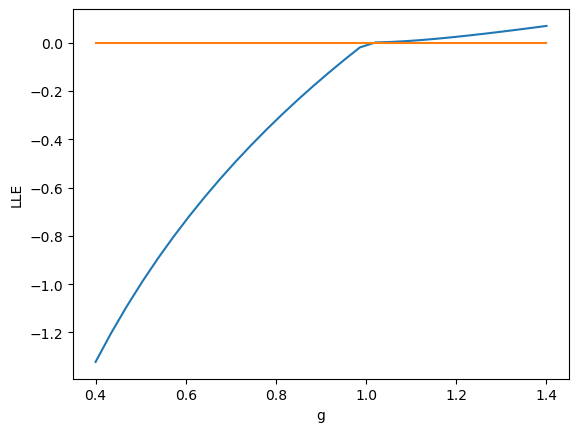

In [12]:
gs=np.linspace(.4,1.4,30)
LLEs=[]
for g in gs: 
    LLEs.append(LLE(g=g,th=0,J0=0,sig=0,f="tanh"))
plt.plot(gs, LLEs)
plt.plot(gs,np.zeros_like(gs))
plt.xlabel("g")
plt.ylabel("LLE")

# The bistable regime

In [24]:
# Now let's plot the solutions for a range of sigmas:

def bistability_plot(th=0.5,g=18,J0=0.5,sig_min=.16,sig_max=.22,pointsc=50):

    M1 = np.zeros(pointsc)
    M2 = np.zeros(pointsc)
    C1 = np.zeros(pointsc)
    C2 = np.zeros(pointsc)
    L1 = np.zeros(pointsc)
    L2 = np.zeros(pointsc)
    loc1 = np.zeros(pointsc)
    loc2 = np.zeros(pointsc)
    
    f="pos"
    sigmas=np.linspace(sig_min,sig_max,pointsc)

    for i,sig in tqdm(enumerate(sigmas)):

        M,C=root_finder(M=10,C=10,g=g,th=th,J0=J0,sig=sig,f=f)
        M1[i]=M
        C1[i]=C

        M,C=root_finder(M=-10,C=10,g=g,th=th,J0=J0,sig=sig,f=f)
        M2[i]=M
        C2[i]=C

        L1[i]=LLE_func(M1[i],C1[i],g=g,th=th,J0=J0,sig=sig,f=f)
        L2[i]=LLE_func(M2[i],C2[i],g=g,th=th,J0=J0,sig=sig,f=f)

        loc1[i]=loc_func(M1[i],C1[i],g=g,th=th,J0=J0,sig=sig,f=f)
        loc2[i]=loc_func(M2[i],C2[i],g=g,th=th,J0=J0,sig=sig,f=f)
        
    fig, ax = plt.subplots(4,1, figsize=(14,15))

    ax=plt.subplot(4,1,1) 
    ax.set_xlabel("$\sigma$")
    ax.set_ylabel("LLE")
    ax.plot(sigmas,L1, color='red', marker='o',linewidth=0)
    ax.plot(sigmas,L1, color='white', marker='.',linewidth=0)
    ax.plot(sigmas,L2, color='blue', marker='.',linewidth=0)
    
    ax1=plt.subplot(4,1,2) 
    ax1.plot(sigmas,M1, color='red', marker='o',linewidth=0)
    ax1.plot(sigmas,M1, color='white', marker='.',linewidth=0)
    ax1.plot(sigmas,M2, color='blue', marker='.',linewidth=0)
    ax1.set_ylabel("M")
    
    ax2=plt.subplot(4,1,3) 
    ax2.set_ylabel("C")
    ax2.plot(sigmas,C1, color='red', marker='o',linewidth=0)
    ax2.plot(sigmas,C1, color='white', marker='.',linewidth=0)
    ax2.plot(sigmas,C2, color='blue', marker='.',linewidth=0)
    
    ax3=plt.subplot(4,1,4) 
    ax3.set_xlabel("$\sigma$")
    ax3.set_ylabel("1-replica stability")
    ax3.plot(sigmas,loc1, color='red', marker='o',linewidth=0)
    ax3.plot(sigmas,loc1, color='white', marker='.',linewidth=0)
    ax3.plot(sigmas,loc2, color='blue', marker='.',linewidth=0)
    ax3.plot(sigmas,np.zeros_like(sigmas),"-k")
    

20it [00:33,  1.66s/it]


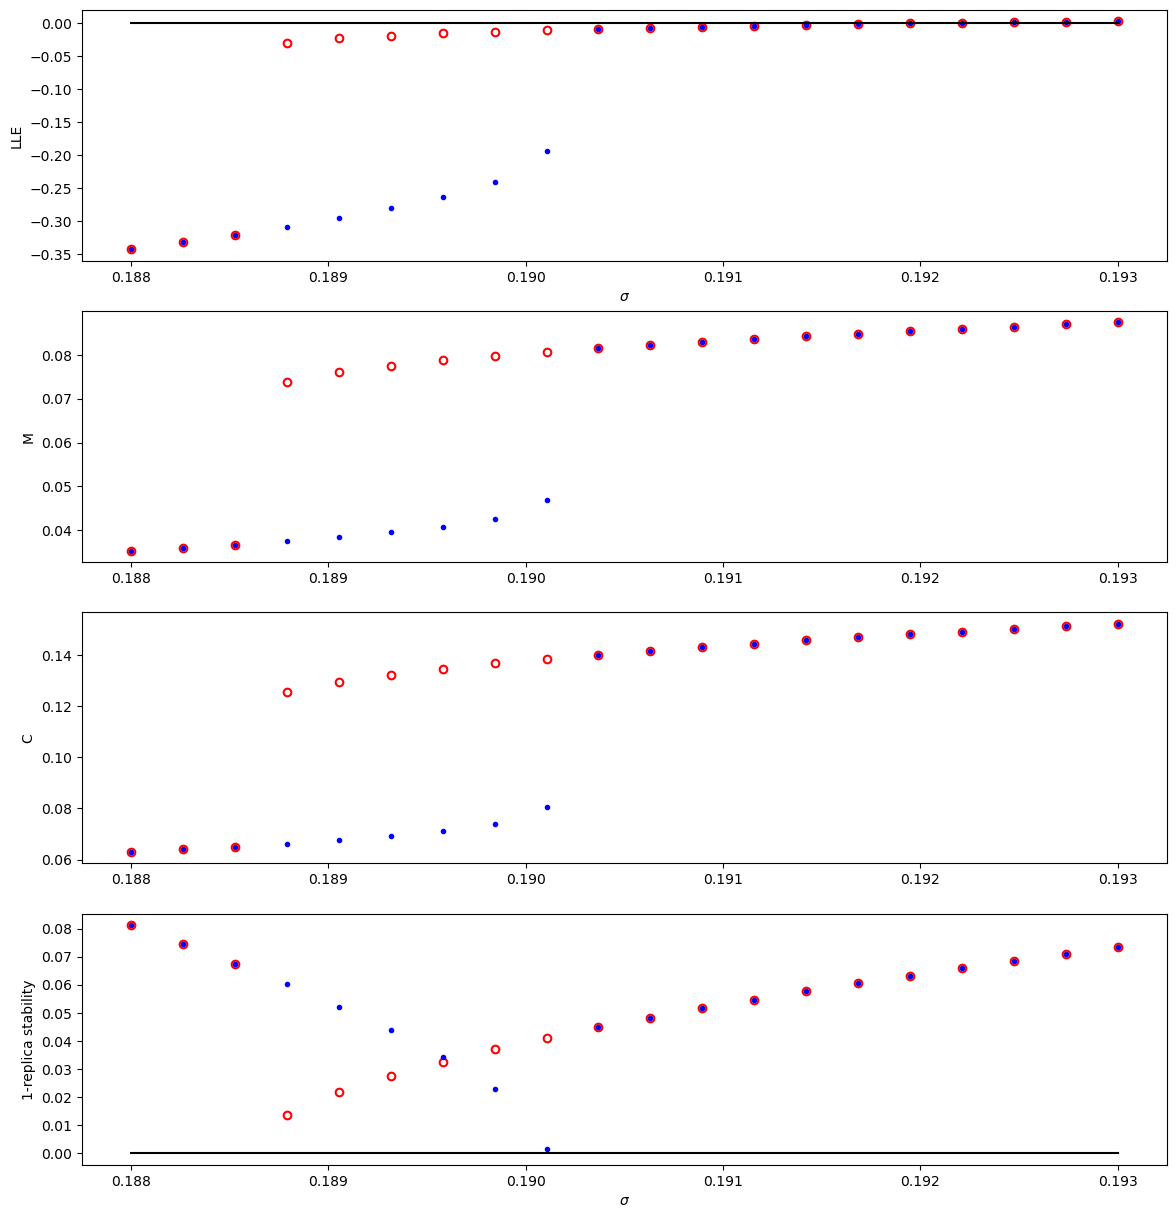

In [25]:
bistability_plot(th=0.4885,g=5,J0=0.5,sig_min=0.188,sig_max=.193,pointsc=20)